<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/Search_2Ch_FitGenerate/Search_2Ch_Base_Normal_FitGenerate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install mne

     |████████████████████████████████| 6.4MB 2.6MB/s 


In [0]:
'''
Rivision:
980804:
  Differenet in/out shift Sampling
  The model is revised to addapt with fit_generate
  All Generators are merged.

980805:
  Option is added to disable orthogonal pre-process  
  
  
  

'''

In [0]:
# Parameters:

EpochNum=25
subject_number=109
RemoveBaseLine=0
Orthogonal=1
task_index = [1] # task: REO
Best1Channel=[61] #Oz
TryStr='Try3_2'


task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
#sample_shift = 4 #step len
inner_sample_shift = 4 # inner step len
outer_sample_shift =8  # outer step len
window_len= 20
batch_size=64

Search_Space_Channel = [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]
Search_Space_Channel_Name=["Fp1","Fp2","F7","F3","Fz","F4","F8","T7","C3","Cz","C4","T8","P7","P3","Pz","P4","P8","O1","Oz","O2"]

# Channel Indexes:
#   Fp1,21
#   Fp2,23
#   F7,29
#   F3,31
#   Fz,33
#   F4,35
#   F8,36
#   T7,40
#   C3,8
#   Cz,10
#   C4,12
#   T8,41
#   P7,46
#   P3,48
#   Pz,50
#   P4,52
#   P8,54
#   O1,60
#   Oz,61
#   O2,62

#   T9,42
#   T10,43


In [0]:
# For Visualization
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# General use
import numpy as np
import math
import random

# For clear memory
import gc

#
import copy 
import csv
import pandas as pd
import datetime
import time
import os


# To download file from google drive
from google.colab import files

# For model training
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from keras import optimizers
from keras import backend as KerasBackend


# EEG Tools
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)



Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


Automatically created module for IPython interactive environment


In [0]:
# load dataset in array

task_number= len(task_index)

# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_number
for x in range(subject_number):
  list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index,path='/content/drive/My Drive/Deep Results/Database',update_path=False)

list_rawdata = np.zeros((subject_number,task_number), dtype='object')

for i in range(subject_number):
  for j in range(task_number):
    list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)



[........................................] 100.00% (  1.2 MB,   1.1 MB/s) -
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) \
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) |
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) |
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) |
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) -
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) \
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) |
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) \
[........................................] 100.00% (  1.2 MB,   1.0 MB/s) \
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) \
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) /
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) /
[...........

In [0]:
# img for each subject
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec - (window_len-1 )*inner_sample_shift) / outer_sample_shift) +1

subject_number_array_shuffled=np.arange(subject_number)
np.random.shuffle(subject_number_array_shuffled)

subject_img_number_array_shuffled=np.arange(subject_img_number)
np.random.shuffle(subject_img_number_array_shuffled)


train_index = len(subject_img_number_array_shuffled)//2
val_index = train_index + len(subject_img_number_array_shuffled)//4

train_shuff = subject_img_number_array_shuffled[:train_index]
val_shuff = subject_img_number_array_shuffled[train_index:val_index]
test_shuff = subject_img_number_array_shuffled[val_index:]


train_number = len(train_shuff)
val_number = len(val_shuff)
test_number = len(test_shuff)


In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

def ProjectionVector(VecA,VecB):
    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA
    return Projeted_VecB_on_VecA

In [0]:
#################################################################################################
## Define General Data Generator
def GenerateGeneralData(BatchSize,ListRawDataMain,SubjectArrayShuffled,ListChannel,RemoveBaseLineFlag,OrthogonalFlag,ImageArrayShuffled,WindowLen,OuterSampleShift,InnerSampleShift,SampelNumberPerSec):
    
    Iter=0
    ch_number=len(ListChannel)
    
    
    ##########################################################
    # Pre-Proceesing On Raw Data
    ListRawDataTemp=ListRawDataMain.copy()
    
    DataAllChannelsRawPerSubject, times =(ListRawDataTemp[0][0][:64,:9600])

    DataChannelsRaw   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsNormal=np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsOrt   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
        
    for s in SubjectArrayShuffled:

        DataAllChannelsRawPerSubject, times =(ListRawDataTemp[s][0][:64,:9600])
        
        # Extrac Channel T9 or T10 as Baseline
        DataChannelT9Raw =DataAllChannelsRawPerSubject[43]# Ch T9 (42) or T10 (43)


        ch_max =[]
        ch_min =[]
        # Extract Selected Channels+ Remove Baseline+ Normailze
        for i in range(len(ListChannel)):
            DataChannelsRaw[s][i]=DataAllChannelsRawPerSubject[ListChannel[i]].copy() -DataChannelT9Raw*RemoveBaseLineFlag

            ch_max = np.append(ch_max, max(DataChannelsRaw[s][i])) # max for each cannel
            ch_min = np.append(ch_min, min(DataChannelsRaw[s][i])) # min for each cannel

            DataChannelsNormal[s][i]=normalize_channel_data(DataChannelsRaw[s][i].copy(), i, ch_min, ch_max)


        # Orthogonal Channel
        DataChannelsOrt[s][0]=DataChannelsNormal[s][0]
        DataChannelsOrt[s][1]=DataChannelsNormal[s][1]-ProjectionVector(DataChannelsNormal[s][0].copy(),DataChannelsNormal[s][1].copy())*OrthogonalFlag
        
        
        
    ##########################################################
    # Generate Data for Network
    while True:

      for j in ImageArrayShuffled:
          for s in SubjectArrayShuffled:

              if Iter ==0:
                  TrainImage=np.zeros((BatchSize, ch_number, WindowLen, SampelNumberPerSec), dtype = float)
                  TrainLabel=np.zeros((BatchSize),dtype=int)

              for i in range(len(ListChannel)):
                  for z in range (WindowLen):
                      ExtractedData = DataChannelsOrt[s][i][0+j*OuterSampleShift + z*InnerSampleShift:SampelNumberPerSec+ j*OuterSampleShift + z*InnerSampleShift]
                      TrainImage[Iter][i][z] = ExtractedData.copy()# Data

              TrainLabel[Iter] = s # label

              Iter=Iter+1
              #Count=Count+1
              if Iter==BatchSize:
                Iter=0
                #print('Count=',Count)
                TrainLabelClass=to_categorical(TrainLabel,len(SubjectArrayShuffled))
                yield TrainImage, TrainLabelClass 

                

#################################################################################################
Index: 0  > Channel: Fp1











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/25
997/997 [==============================] - 38s 38ms/step - loss: 4.2665 - acc: 0.0506 - val_loss: 3.4582 - val_acc: 0.1851
Epoch 2/25
997/997 [==============================] - 33s 33ms/step - loss: 3.1647 - acc: 0.1742 - val_loss: 2.3706 - val_acc: 0.4079
Epoch 3/25
997/997 [==============================] - 33s 33ms/step - loss: 2.4224 - acc: 0.3134 - val_loss: 1.7721 - val_acc: 0.5306
Epoch 4/25
997/997 [==============================] - 33s 33ms/step - loss: 1.8836 - acc: 0.4418 - val_loss: 1.2818 - val_acc: 0.6616
Epoch 5/25
997/997 [==============================] - 33s 33ms/step - loss: 1.4805 - acc: 0.5460 - val_loss: 0.9699 -

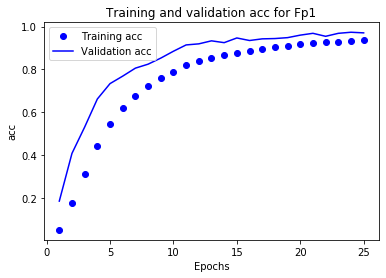


#################################################################################################
Index: 1  > Channel: Fp2
Epoch 1/25
997/997 [==============================] - 34s 34ms/step - loss: 4.2877 - acc: 0.0523 - val_loss: 3.4478 - val_acc: 0.1957
Epoch 2/25
997/997 [==============================] - 32s 33ms/step - loss: 3.1813 - acc: 0.1823 - val_loss: 2.3820 - val_acc: 0.4001
Epoch 3/25
997/997 [==============================] - 32s 33ms/step - loss: 2.4065 - acc: 0.3248 - val_loss: 1.7837 - val_acc: 0.5142
Epoch 4/25
997/997 [==============================] - 32s 33ms/step - loss: 1.8992 - acc: 0.4348 - val_loss: 1.4452 - val_acc: 0.5879
Epoch 5/25
997/997 [==============================] - 32s 33ms/step - loss: 1.5698 - acc: 0.5156 - val_loss: 1.0864 - val_acc: 0.6989
Epoch 6/25
997/997 [==============================] - 32s 32ms/step - loss: 1.3144 - acc: 0.5865 - val_loss: 0.8626 - val_acc: 0.7590
Epoch 7/25
997/997 [==============================] - 33s 33ms/step - lo

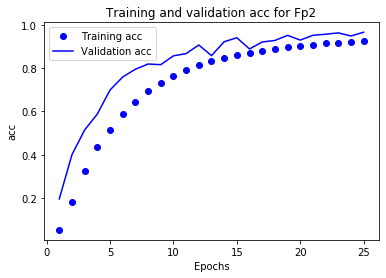

#################################################################################################
Index: 2  > Channel: F7
Epoch 1/25
997/997 [==============================] - 34s 34ms/step - loss: 4.3017 - acc: 0.0498 - val_loss: 3.5262 - val_acc: 0.1740
Epoch 2/25
997/997 [==============================] - 32s 32ms/step - loss: 3.2137 - acc: 0.1668 - val_loss: 2.4256 - val_acc: 0.4061
Epoch 3/25
997/997 [==============================] - 32s 32ms/step - loss: 2.4128 - acc: 0.3164 - val_loss: 1.7592 - val_acc: 0.5400
Epoch 4/25
997/997 [==============================] - 32s 32ms/step - loss: 1.8429 - acc: 0.4515 - val_loss: 1.3047 - val_acc: 0.6546
Epoch 5/25
997/997 [==============================] - 32s 32ms/step - loss: 1.4244 - acc: 0.5657 - val_loss: 0.9281 - val_acc: 0.7512
Epoch 6/25
997/997 [==============================] - 33s 33ms/step - loss: 1.1491 - acc: 0.6431 - val_loss: 0.7251 - val_acc: 0.7966
Epoch 7/25
997/997 [==============================] - 32s 32ms/step - loss

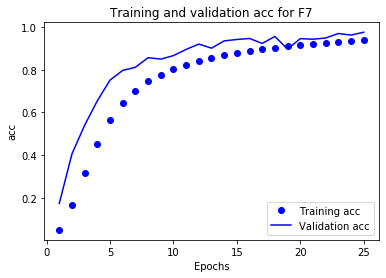

#################################################################################################
Index: 3  > Channel: F3
Epoch 1/25
997/997 [==============================] - 34s 34ms/step - loss: 4.3346 - acc: 0.0466 - val_loss: 3.6167 - val_acc: 0.1521
Epoch 2/25
997/997 [==============================] - 32s 33ms/step - loss: 3.3374 - acc: 0.1601 - val_loss: 2.6266 - val_acc: 0.3565
Epoch 3/25
997/997 [==============================] - 32s 33ms/step - loss: 2.5771 - acc: 0.2924 - val_loss: 1.9180 - val_acc: 0.5205
Epoch 4/25
997/997 [==============================] - 32s 32ms/step - loss: 1.9892 - acc: 0.4251 - val_loss: 1.4418 - val_acc: 0.6262
Epoch 5/25
997/997 [==============================] - 32s 32ms/step - loss: 1.5402 - acc: 0.5374 - val_loss: 1.0190 - val_acc: 0.7331
Epoch 6/25
997/997 [==============================] - 32s 33ms/step - loss: 1.2205 - acc: 0.6247 - val_loss: 0.8104 - val_acc: 0.7738
Epoch 7/25
997/997 [==============================] - 33s 33ms/step - loss

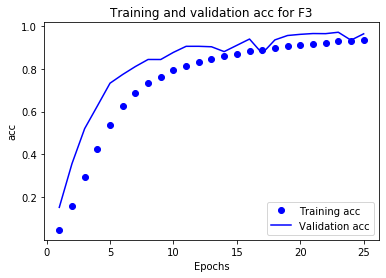

#################################################################################################
Index: 4  > Channel: Fz
Epoch 1/25
997/997 [==============================] - 34s 34ms/step - loss: 4.4041 - acc: 0.0399 - val_loss: 3.8216 - val_acc: 0.0925
Epoch 2/25
997/997 [==============================] - 32s 32ms/step - loss: 3.5266 - acc: 0.1272 - val_loss: 2.8382 - val_acc: 0.3154
Epoch 3/25
997/997 [==============================] - 32s 32ms/step - loss: 2.6889 - acc: 0.2652 - val_loss: 2.0346 - val_acc: 0.4841
Epoch 4/25
997/997 [==============================] - 32s 32ms/step - loss: 2.0358 - acc: 0.4066 - val_loss: 1.4384 - val_acc: 0.6236
Epoch 5/25
997/997 [==============================] - 33s 33ms/step - loss: 1.5732 - acc: 0.5252 - val_loss: 1.0288 - val_acc: 0.7252
Epoch 6/25
997/997 [==============================] - 33s 33ms/step - loss: 1.2426 - acc: 0.6183 - val_loss: 0.8252 - val_acc: 0.7678
Epoch 7/25
997/997 [==============================] - 33s 33ms/step - loss

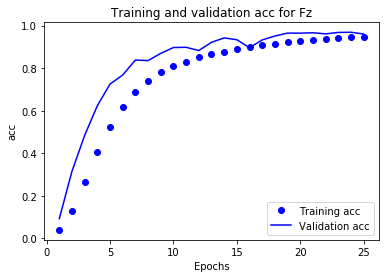

#################################################################################################
Index: 5  > Channel: F4
Epoch 1/25
997/997 [==============================] - 34s 34ms/step - loss: 4.3267 - acc: 0.0460 - val_loss: 3.6516 - val_acc: 0.1499
Epoch 2/25
997/997 [==============================] - 33s 33ms/step - loss: 3.3828 - acc: 0.1559 - val_loss: 2.6409 - val_acc: 0.3722
Epoch 3/25
997/997 [==============================] - 33s 33ms/step - loss: 2.4687 - acc: 0.3217 - val_loss: 1.7082 - val_acc: 0.5894
Epoch 4/25
997/997 [==============================] - 33s 33ms/step - loss: 1.8032 - acc: 0.4712 - val_loss: 1.2084 - val_acc: 0.6929
Epoch 5/25
997/997 [==============================] - 33s 33ms/step - loss: 1.3817 - acc: 0.5803 - val_loss: 0.8676 - val_acc: 0.7695
Epoch 6/25
997/997 [==============================] - 32s 33ms/step - loss: 1.1048 - acc: 0.6583 - val_loss: 0.7047 - val_acc: 0.7980
Epoch 7/25
997/997 [==============================] - 32s 32ms/step - loss

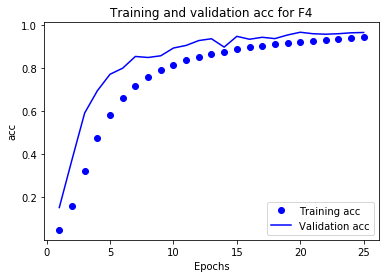

#################################################################################################
Index: 6  > Channel: F8
Epoch 1/25
997/997 [==============================] - 34s 34ms/step - loss: 4.2825 - acc: 0.0474 - val_loss: 3.5654 - val_acc: 0.1605
Epoch 2/25
997/997 [==============================] - 33s 33ms/step - loss: 3.2661 - acc: 0.1656 - val_loss: 2.5235 - val_acc: 0.3978
Epoch 3/25
997/997 [==============================] - 32s 32ms/step - loss: 2.3544 - acc: 0.3480 - val_loss: 1.5992 - val_acc: 0.6116
Epoch 4/25
997/997 [==============================] - 32s 33ms/step - loss: 1.6215 - acc: 0.5201 - val_loss: 0.9951 - val_acc: 0.7517
Epoch 5/25
997/997 [==============================] - 32s 33ms/step - loss: 1.1821 - acc: 0.6351 - val_loss: 0.6992 - val_acc: 0.8154
Epoch 6/25
997/997 [==============================] - 32s 33ms/step - loss: 0.9307 - acc: 0.7074 - val_loss: 0.5470 - val_acc: 0.8483
Epoch 7/25
997/997 [==============================] - 32s 33ms/step - loss

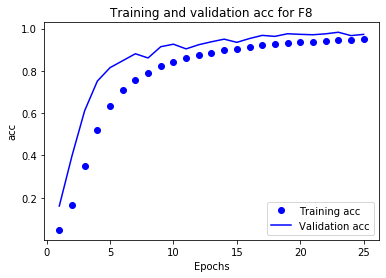

#################################################################################################
Index: 7  > Channel: T7
Epoch 1/25
997/997 [==============================] - 34s 34ms/step - loss: 4.2357 - acc: 0.0539 - val_loss: 3.3962 - val_acc: 0.2284
Epoch 2/25
997/997 [==============================] - 33s 33ms/step - loss: 3.0662 - acc: 0.2089 - val_loss: 2.2876 - val_acc: 0.4409
Epoch 3/25
997/997 [==============================] - 32s 33ms/step - loss: 2.1958 - acc: 0.3852 - val_loss: 1.5292 - val_acc: 0.6050
Epoch 4/25
997/997 [==============================] - 32s 33ms/step - loss: 1.6572 - acc: 0.5143 - val_loss: 1.2244 - val_acc: 0.6659
Epoch 5/25
997/997 [==============================] - 33s 33ms/step - loss: 1.3085 - acc: 0.6067 - val_loss: 0.9377 - val_acc: 0.7401
Epoch 6/25
997/997 [==============================] - 32s 32ms/step - loss: 1.0608 - acc: 0.6742 - val_loss: 0.7264 - val_acc: 0.7909
Epoch 7/25
997/997 [==============================] - 32s 32ms/step - loss

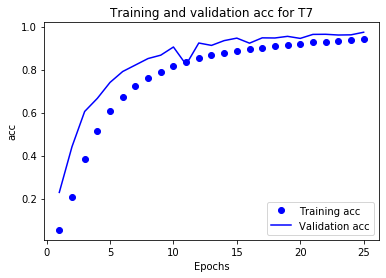

#################################################################################################
Index: 8  > Channel: C3
Epoch 1/25
997/997 [==============================] - 34s 35ms/step - loss: 4.2563 - acc: 0.0454 - val_loss: 3.4589 - val_acc: 0.1779
Epoch 2/25
997/997 [==============================] - 33s 33ms/step - loss: 3.1794 - acc: 0.1714 - val_loss: 2.3930 - val_acc: 0.4043
Epoch 3/25
997/997 [==============================] - 33s 33ms/step - loss: 2.3691 - acc: 0.3296 - val_loss: 1.7261 - val_acc: 0.5533
Epoch 4/25
997/997 [==============================] - 33s 33ms/step - loss: 1.8420 - acc: 0.4567 - val_loss: 1.3884 - val_acc: 0.6194
Epoch 5/25
997/997 [==============================] - 33s 33ms/step - loss: 1.4757 - acc: 0.5541 - val_loss: 1.0848 - val_acc: 0.6884
Epoch 6/25
997/997 [==============================] - 33s 33ms/step - loss: 1.1954 - acc: 0.6319 - val_loss: 0.8292 - val_acc: 0.7610
Epoch 7/25
997/997 [==============================] - 33s 33ms/step - loss

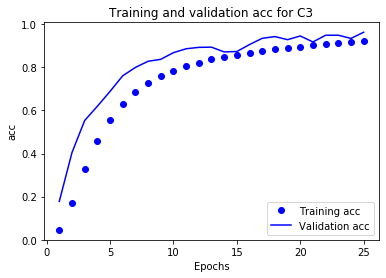

#################################################################################################
Index: 9  > Channel: Cz
Epoch 1/25
997/997 [==============================] - 34s 34ms/step - loss: 4.1417 - acc: 0.0583 - val_loss: 3.2262 - val_acc: 0.2187
Epoch 2/25
997/997 [==============================] - 32s 33ms/step - loss: 2.9588 - acc: 0.2045 - val_loss: 2.1338 - val_acc: 0.4780
Epoch 3/25
997/997 [==============================] - 33s 33ms/step - loss: 2.2089 - acc: 0.3494 - val_loss: 1.5688 - val_acc: 0.5930
Epoch 4/25
997/997 [==============================] - 33s 33ms/step - loss: 1.7755 - acc: 0.4603 - val_loss: 1.2384 - val_acc: 0.6717
Epoch 5/25
997/997 [==============================] - 33s 33ms/step - loss: 1.4572 - acc: 0.5509 - val_loss: 0.9922 - val_acc: 0.7243
Epoch 6/25
997/997 [==============================] - 33s 33ms/step - loss: 1.2199 - acc: 0.6212 - val_loss: 0.8416 - val_acc: 0.7618
Epoch 7/25
997/997 [==============================] - 32s 33ms/step - loss

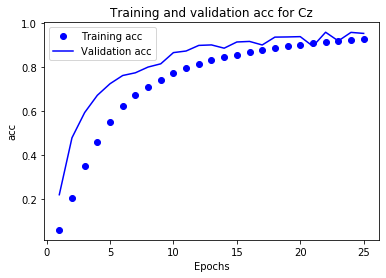

#################################################################################################
Index: 10  > Channel: C4
Epoch 1/25
997/997 [==============================] - 34s 35ms/step - loss: 4.1717 - acc: 0.0650 - val_loss: 3.2802 - val_acc: 0.2207
Epoch 2/25
997/997 [==============================] - 33s 33ms/step - loss: 2.9886 - acc: 0.2176 - val_loss: 2.1914 - val_acc: 0.4511
Epoch 3/25
997/997 [==============================] - 33s 33ms/step - loss: 2.1804 - acc: 0.3786 - val_loss: 1.5873 - val_acc: 0.5830
Epoch 4/25
997/997 [==============================] - 33s 33ms/step - loss: 1.6805 - acc: 0.4998 - val_loss: 1.2130 - val_acc: 0.6653
Epoch 5/25
997/997 [==============================] - 33s 33ms/step - loss: 1.3369 - acc: 0.5931 - val_loss: 0.9327 - val_acc: 0.7392
Epoch 6/25
997/997 [==============================] - 33s 33ms/step - loss: 1.0862 - acc: 0.6648 - val_loss: 0.7120 - val_acc: 0.7999
Epoch 7/25
997/997 [==============================] - 33s 33ms/step - los

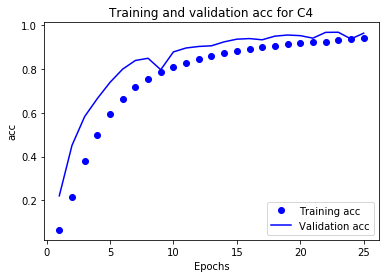

#################################################################################################
Index: 11  > Channel: T8
Epoch 1/25
997/997 [==============================] - 35s 35ms/step - loss: 4.3062 - acc: 0.0460 - val_loss: 3.6196 - val_acc: 0.1344
Epoch 2/25
997/997 [==============================] - 33s 33ms/step - loss: 3.3704 - acc: 0.1495 - val_loss: 2.7373 - val_acc: 0.3272
Epoch 3/25
997/997 [==============================] - 33s 33ms/step - loss: 2.4879 - acc: 0.3189 - val_loss: 1.7007 - val_acc: 0.6051
Epoch 4/25
997/997 [==============================] - 33s 33ms/step - loss: 1.7877 - acc: 0.4786 - val_loss: 1.2817 - val_acc: 0.6700
Epoch 5/25
997/997 [==============================] - 33s 33ms/step - loss: 1.3268 - acc: 0.6018 - val_loss: 0.8690 - val_acc: 0.7628
Epoch 6/25
997/997 [==============================] - 34s 34ms/step - loss: 1.0349 - acc: 0.6809 - val_loss: 0.6607 - val_acc: 0.8089
Epoch 7/25
997/997 [==============================] - 33s 33ms/step - los

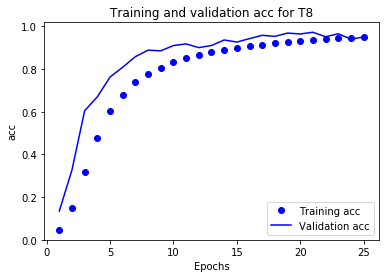

#################################################################################################
Index: 12  > Channel: P7
Epoch 1/25
997/997 [==============================] - 35s 35ms/step - loss: 4.3035 - acc: 0.0441 - val_loss: 3.5203 - val_acc: 0.1527
Epoch 2/25
997/997 [==============================] - 33s 33ms/step - loss: 3.0987 - acc: 0.2001 - val_loss: 2.1287 - val_acc: 0.4832
Epoch 3/25
997/997 [==============================] - 33s 33ms/step - loss: 2.0537 - acc: 0.4036 - val_loss: 1.3027 - val_acc: 0.6680
Epoch 4/25
997/997 [==============================] - 33s 33ms/step - loss: 1.4340 - acc: 0.5547 - val_loss: 0.9269 - val_acc: 0.7541
Epoch 5/25
997/997 [==============================] - 33s 33ms/step - loss: 1.1006 - acc: 0.6492 - val_loss: 0.6816 - val_acc: 0.8032
Epoch 6/25
997/997 [==============================] - 33s 33ms/step - loss: 0.8868 - acc: 0.7116 - val_loss: 0.5559 - val_acc: 0.8381
Epoch 7/25
997/997 [==============================] - 33s 33ms/step - los

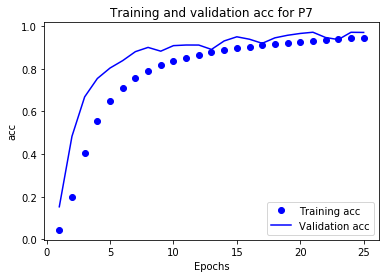

#################################################################################################
Index: 13  > Channel: P3
Epoch 1/25
997/997 [==============================] - 35s 35ms/step - loss: 4.1870 - acc: 0.0538 - val_loss: 3.2804 - val_acc: 0.2633
Epoch 2/25
997/997 [==============================] - 33s 33ms/step - loss: 2.8762 - acc: 0.2475 - val_loss: 2.0091 - val_acc: 0.5003
Epoch 3/25
997/997 [==============================] - 33s 33ms/step - loss: 1.9779 - acc: 0.4291 - val_loss: 1.3181 - val_acc: 0.6559
Epoch 4/25
997/997 [==============================] - 33s 33ms/step - loss: 1.5003 - acc: 0.5508 - val_loss: 0.9764 - val_acc: 0.7352
Epoch 5/25
997/997 [==============================] - 33s 33ms/step - loss: 1.1875 - acc: 0.6333 - val_loss: 0.7768 - val_acc: 0.7710
Epoch 6/25
997/997 [==============================] - 33s 33ms/step - loss: 0.9749 - acc: 0.6954 - val_loss: 0.6568 - val_acc: 0.8004
Epoch 7/25
997/997 [==============================] - 33s 33ms/step - los

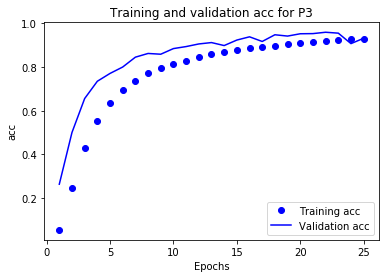

#################################################################################################
Index: 14  > Channel: Pz
Epoch 1/25
997/997 [==============================] - 34s 35ms/step - loss: 4.3775 - acc: 0.0436 - val_loss: 3.6721 - val_acc: 0.1377
Epoch 2/25
997/997 [==============================] - 33s 33ms/step - loss: 3.4244 - acc: 0.1494 - val_loss: 2.7135 - val_acc: 0.3462
Epoch 3/25
997/997 [==============================] - 33s 33ms/step - loss: 2.6537 - acc: 0.2861 - val_loss: 1.9658 - val_acc: 0.4949
Epoch 4/25
997/997 [==============================] - 33s 33ms/step - loss: 2.0904 - acc: 0.4028 - val_loss: 1.4609 - val_acc: 0.6223
Epoch 5/25
997/997 [==============================] - 33s 33ms/step - loss: 1.6589 - acc: 0.5066 - val_loss: 1.1269 - val_acc: 0.6980
Epoch 6/25
997/997 [==============================] - 33s 33ms/step - loss: 1.3610 - acc: 0.5827 - val_loss: 0.9930 - val_acc: 0.7114
Epoch 7/25
997/997 [==============================] - 33s 33ms/step - los

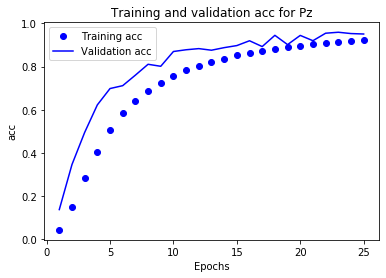

#################################################################################################
Index: 15  > Channel: P4
Epoch 1/25
997/997 [==============================] - 35s 35ms/step - loss: 4.1947 - acc: 0.0561 - val_loss: 3.2976 - val_acc: 0.2071
Epoch 2/25
997/997 [==============================] - 33s 33ms/step - loss: 3.0028 - acc: 0.2197 - val_loss: 2.1414 - val_acc: 0.4621
Epoch 3/25
997/997 [==============================] - 33s 33ms/step - loss: 2.1234 - acc: 0.3980 - val_loss: 1.4637 - val_acc: 0.6002
Epoch 4/25
997/997 [==============================] - 33s 33ms/step - loss: 1.6057 - acc: 0.5165 - val_loss: 1.0431 - val_acc: 0.7166
Epoch 5/25
997/997 [==============================] - 33s 33ms/step - loss: 1.2698 - acc: 0.6065 - val_loss: 0.8130 - val_acc: 0.7737
Epoch 6/25
997/997 [==============================] - 33s 33ms/step - loss: 1.0358 - acc: 0.6705 - val_loss: 0.6595 - val_acc: 0.8066
Epoch 7/25
997/997 [==============================] - 33s 33ms/step - los

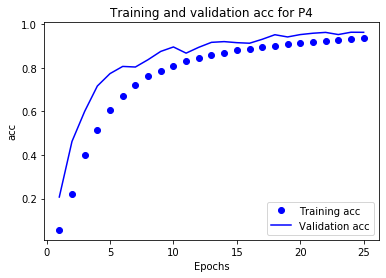

#################################################################################################
Index: 16  > Channel: P8
Epoch 1/25
997/997 [==============================] - 34s 35ms/step - loss: 4.2805 - acc: 0.0484 - val_loss: 3.5128 - val_acc: 0.1779
Epoch 2/25
997/997 [==============================] - 32s 32ms/step - loss: 3.1641 - acc: 0.1923 - val_loss: 2.3018 - val_acc: 0.4456
Epoch 3/25
997/997 [==============================] - 32s 33ms/step - loss: 2.1978 - acc: 0.3850 - val_loss: 1.4219 - val_acc: 0.6672
Epoch 4/25
997/997 [==============================] - 32s 32ms/step - loss: 1.5641 - acc: 0.5372 - val_loss: 0.9978 - val_acc: 0.7514
Epoch 5/25
997/997 [==============================] - 33s 33ms/step - loss: 1.1908 - acc: 0.6340 - val_loss: 0.7168 - val_acc: 0.8132
Epoch 6/25
997/997 [==============================] - 32s 33ms/step - loss: 0.9586 - acc: 0.7017 - val_loss: 0.5929 - val_acc: 0.8394
Epoch 7/25
997/997 [==============================] - 33s 33ms/step - los

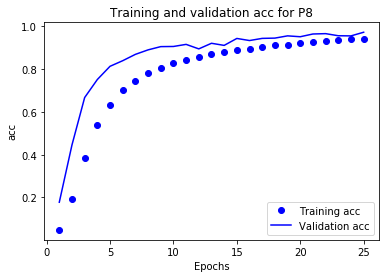

#################################################################################################
Index: 17  > Channel: O1
Epoch 1/25
997/997 [==============================] - 34s 34ms/step - loss: 4.3172 - acc: 0.0521 - val_loss: 3.6603 - val_acc: 0.1337
Epoch 2/25
997/997 [==============================] - 32s 33ms/step - loss: 3.4453 - acc: 0.1452 - val_loss: 2.7835 - val_acc: 0.3401
Epoch 3/25
997/997 [==============================] - 32s 32ms/step - loss: 2.6953 - acc: 0.2709 - val_loss: 2.0229 - val_acc: 0.4939
Epoch 4/25
997/997 [==============================] - 32s 32ms/step - loss: 2.0956 - acc: 0.3986 - val_loss: 1.6355 - val_acc: 0.5626
Epoch 5/25
997/997 [==============================] - 32s 32ms/step - loss: 1.6426 - acc: 0.5088 - val_loss: 1.1174 - val_acc: 0.7121
Epoch 6/25
997/997 [==============================] - 32s 32ms/step - loss: 1.2999 - acc: 0.6001 - val_loss: 0.8346 - val_acc: 0.7771
Epoch 7/25
997/997 [==============================] - 32s 32ms/step - los

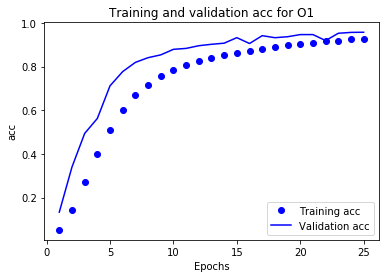

#################################################################################################
Index: 18  > Channel: Oz
  Same channel as previously selected channels.
Epoch 1/25
997/997 [==============================] - 34s 34ms/step - loss: 4.3000 - acc: 0.0390 - val_loss: 3.5001 - val_acc: 0.1433
Epoch 2/25
997/997 [==============================] - 32s 32ms/step - loss: 3.1471 - acc: 0.1554 - val_loss: 2.4476 - val_acc: 0.3430
Epoch 3/25
997/997 [==============================] - 32s 32ms/step - loss: 2.5220 - acc: 0.2633 - val_loss: 1.9622 - val_acc: 0.4715
Epoch 4/25
997/997 [==============================] - 32s 32ms/step - loss: 2.0991 - acc: 0.3649 - val_loss: 1.7166 - val_acc: 0.5035
Epoch 5/25
997/997 [==============================] - 32s 32ms/step - loss: 1.8015 - acc: 0.4407 - val_loss: 1.3537 - val_acc: 0.6165
Epoch 6/25
997/997 [==============================] - 32s 32ms/step - loss: 1.6052 - acc: 0.4915 - val_loss: 1.2752 - val_acc: 0.6139
Epoch 7/25
997/997 [=====

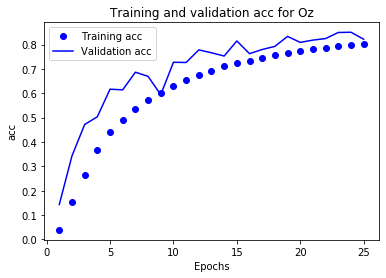

#################################################################################################
Index: 19  > Channel: O2
Epoch 1/25
997/997 [==============================] - 34s 34ms/step - loss: 4.2841 - acc: 0.0474 - val_loss: 3.5732 - val_acc: 0.1777
Epoch 2/25
997/997 [==============================] - 32s 32ms/step - loss: 3.2226 - acc: 0.1802 - val_loss: 2.4865 - val_acc: 0.3875
Epoch 3/25
997/997 [==============================] - 32s 32ms/step - loss: 2.4010 - acc: 0.3342 - val_loss: 1.7049 - val_acc: 0.5669
Epoch 4/25
997/997 [==============================] - 32s 32ms/step - loss: 1.8198 - acc: 0.4689 - val_loss: 1.2443 - val_acc: 0.6644
Epoch 5/25
997/997 [==============================] - 32s 32ms/step - loss: 1.4355 - acc: 0.5683 - val_loss: 1.0110 - val_acc: 0.7116
Epoch 6/25
997/997 [==============================] - 32s 33ms/step - loss: 1.1693 - acc: 0.6386 - val_loss: 0.7417 - val_acc: 0.7931
Epoch 7/25
997/997 [==============================] - 32s 32ms/step - los

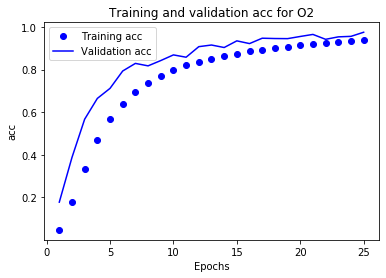

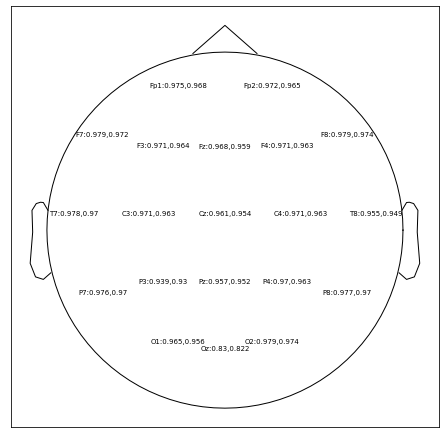

In [0]:
#####################################################################################################
# seacrh all channels


# Read Previous intruppted execution, if any, or create new empty cell
ResultFileName='SearchSpaceResultTable_2Ch_('+str(Best1Channel[0])+')_S'+str(subject_number)
if RemoveBaseLine==0:
  ResultFileName=ResultFileName+"_RemoveBaseLineOff"
else:
  ResultFileName=ResultFileName+"_RemoveBaseLineOn"

if Orthogonal==0:
  ResultFileName=ResultFileName+"_OrthogonalOff"
else:
  ResultFileName=ResultFileName+"_OrthogonalOn"
  
ResultFileName=ResultFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'.csv'

  
if os.path.isfile('/content/drive/My Drive/Deep Results/'+ResultFileName):
#   print("here")
  SearchSpaceResult=pd.read_csv('/content/drive/My Drive/Deep Results/'+ResultFileName, header=None)
#   print(Test)
  SearchSpaceResult=SearchSpaceResult.values
#   print(Test)
  
else:
    SearchSpaceResult=np.zeros((len(Search_Space_Channel),6),dtype = float)



#####################################################################################################
# seacrh all channels

for IndexCh in range(len(Search_Space_Channel)):
    
    #################################################################################################
    # Print Iteration
    print("#################################################################################################")
    print("Index:", IndexCh," > Channel:", Search_Space_Channel_Name[IndexCh])
    
    if(SearchSpaceResult[IndexCh][0]>0):
      print("  Already Done.")
      continue 
    
    
    if(Search_Space_Channel[IndexCh]==Best1Channel[0] ):
      print("  Same channel as previously selected channels.")
      SearchSpaceResult[IndexCh][0]=.1
      #continue
      
    
    #################################################################################################
    # Reset Model and Data Arrays
    list_channel=Best1Channel + [Search_Space_Channel[IndexCh]]
    ch_number=len(list_channel)
    
    list_rawdataTemp=list_rawdata.copy()

        
    #################################################################################################
    # Construct Data Generator

    GenTrainData=GenerateGeneralData(BatchSize=batch_size,
                                     ListRawDataMain=list_rawdataTemp.copy(),
                                     SubjectArrayShuffled=subject_number_array_shuffled,
                                     ListChannel=list_channel,
                                     RemoveBaseLineFlag=RemoveBaseLine,
                                     OrthogonalFlag=Orthogonal,
                                     WindowLen=window_len,
                                     OuterSampleShift=outer_sample_shift,
                                     InnerSampleShift=inner_sample_shift,
                                     SampelNumberPerSec=sampel_number_per_sec,
                                     ImageArrayShuffled=train_shuff)

    GenValidationData =GenerateGeneralData(BatchSize=batch_size,
                                           ListRawDataMain=list_rawdataTemp.copy(),
                                           SubjectArrayShuffled=subject_number_array_shuffled,
                                           ListChannel=list_channel,
                                           RemoveBaseLineFlag=RemoveBaseLine,
                                           OrthogonalFlag=Orthogonal,
                                           WindowLen=window_len,
                                           OuterSampleShift=outer_sample_shift,
                                           InnerSampleShift=inner_sample_shift,
                                           SampelNumberPerSec=sampel_number_per_sec,
                                           ImageArrayShuffled=val_shuff)

    GenTestData=GenerateGeneralData(BatchSize=batch_size,
                                    ListRawDataMain=list_rawdataTemp.copy(),
                                    SubjectArrayShuffled=subject_number_array_shuffled,
                                    ListChannel=list_channel,
                                    RemoveBaseLineFlag=RemoveBaseLine,
                                    OrthogonalFlag=Orthogonal,
                                    WindowLen=window_len,
                                    OuterSampleShift=outer_sample_shift,
                                    InnerSampleShift=inner_sample_shift,
                                    SampelNumberPerSec=sampel_number_per_sec,
                                    ImageArrayShuffled=test_shuff)

    #################################################################################################
    # Create Model
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (ch_number,window_len,160), data_format= "channels_first" ))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(subject_number, activation = 'softmax'))
    
    model.compile(loss= 'categorical_crossentropy',
                  optimizer= optimizers.RMSprop(lr= 1e-4),
                  metrics = ['acc'])
    
    #################################################################################################
    # Train the Model
    history = model.fit_generator(epochs =EpochNum,
                                  generator=GenTrainData,
                                  steps_per_epoch=np.ceil(train_number*subject_number/batch_size),
                                  validation_data=GenValidationData,
                                  validation_steps =np.ceil(val_number*subject_number/batch_size),
                                  use_multiprocessing=False,
                                  workers=1)

    #################################################################################################
    # Evalute the Model
    TrainResult      =model.evaluate_generator(GenTrainData,steps=np.ceil(train_number*subject_number/batch_size))
    ValidationResult =model.evaluate_generator(GenValidationData,steps=np.ceil(val_number*subject_number/batch_size))
    TestResult       =model.evaluate_generator(GenTestData,steps=np.ceil(test_number*subject_number/batch_size))
    print('     TrainResult ([loss , acc])=',TrainResult)
    print('ValidationResult ([loss , acc])=',ValidationResult)
    print('      TestResult ([loss , acc])=',TestResult)
    
    #################################################################################################
    # Extract Result
    #SearchSpaceResult[IndexCh][0]=history.history['loss'][EpochNum-1]
    #SearchSpaceResult[IndexCh][1]=history.history['acc'][EpochNum-1]
    #SearchSpaceResult[IndexCh][2]=history.history['val_loss'][EpochNum-1]
    #SearchSpaceResult[IndexCh][3]=history.history['val_acc'][EpochNum-1]
    
    SearchSpaceResult[IndexCh][0]=TrainResult[0]
    SearchSpaceResult[IndexCh][1]=TrainResult[1]
    SearchSpaceResult[IndexCh][2]=ValidationResult[0]
    SearchSpaceResult[IndexCh][3]=ValidationResult[1]
    SearchSpaceResult[IndexCh][4]=TestResult[0]
    SearchSpaceResult[IndexCh][5]=TestResult[1]
    
    #################################################################################################
    # Save current Result to google drive
    with open('/content/drive/My Drive/Deep Results/'+ResultFileName, 'w+') as csvfile:
      spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
      spamwriter.writerows(SearchSpaceResult)


    #################################################################################################
    # plot accuracy
    history_dict = history.history 
    acc_values = history_dict ['acc'] 
    val_acc_values = history_dict['val_acc']
    epochs = range(1, len(acc_values) + 1)


    #plt.clf()
    plt.plot(epochs, acc_values, 'bo', label='Training acc') 
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
    plt.title('Training and validation acc for '+ Search_Space_Channel_Name[IndexCh]) 
    plt.xlabel('Epochs') 
    plt.ylabel('acc') 
    plt.legend()
    plt.show()

    #################################################################################################
    # Erase Memory
    KerasBackend.clear_session()
    
    del model
    del history
    del TrainResult
    del ValidationResult
    del TestResult
    del GenTrainData
    del GenValidationData
    del GenTestData
    
    KerasBackend.clear_session()
    
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    
#################################################################################################    
## Visualize Results and Save Results
Today = datetime.date.today()
TodayStr = Today.strftime("%Y%m%d")
ResultFileName='SearchSpaceResult_2Ch_('+str(Best1Channel[0])+')_S'+str(subject_number)
ChannelFileName='ChannelNames_2Ch_('+str(Best1Channel[0])+')_S'+str(subject_number)
ImageFileName='SearchSpaceResult_2Ch_('+str(Best1Channel[0])+')_S'+str(subject_number)

if RemoveBaseLine==0:
  ResultFileName=ResultFileName+'_RemoveBaseLineOff'
  ChannelFileName=ChannelFileName+'_RemoveBaseLineOff'
  ImageFileName=ImageFileName+'_RemoveBaseLineOff'
else:
  ResultFileName=ResultFileName+'_RemoveBaseLineOn'
  ChannelFileName=ChannelFileName+'_RemoveBaseLineOn'
  ImageFileName=ImageFileName+'_RemoveBaseLineOn'

if Orthogonal==0:
  ResultFileName=ResultFileName+"_OrthogonalOff"
  ChannelFileName=ChannelFileName+'_OrthogonalOff'
  ImageFileName=ImageFileName+'_OrthogonalOff'
else:
  ResultFileName=ResultFileName+"_OrthogonalOn"
  ChannelFileName=ChannelFileName+'_OrthogonalOn'
  ImageFileName=ImageFileName+'_OrthogonalOn'
  

ResultFileName=ResultFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TodayStr+'.csv'
ChannelFileName=ChannelFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TodayStr+'.csv'
ImageFileName=ImageFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TodayStr+'.pdf'


# Visualize
biosemi_layout = mne.channels.read_layout('biosemi')
biosemi_Acc=copy.deepcopy(biosemi_layout)

for i in range(len(biosemi_Acc.names)):
    biosemi_Acc.names[i]=' '

    
for i in range(len(Search_Space_Channel)):
    index=biosemi_layout.names.index(Search_Space_Channel_Name[i])
    biosemi_Acc.names[index]=biosemi_layout.names[index]+":"+str(np.round(SearchSpaceResult[i][1],3))+\
                                                         ","+str(np.round(SearchSpaceResult[i][5],3))

ImageEEG=biosemi_Acc.plot()
# plt.title("Channel Name : Training Acc.  > Test Acc.",pad=-12)



# Save To Google Drive
ImageEEG.savefig('/content/drive/My Drive/Deep Results/'+ImageFileName)


with open('/content/drive/My Drive/Deep Results/'+ResultFileName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerows(SearchSpaceResult)

with open('/content/drive/My Drive/Deep Results/'+ChannelFileName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(Search_Space_Channel)
    spamwriter.writerow(Search_Space_Channel_Name)

    

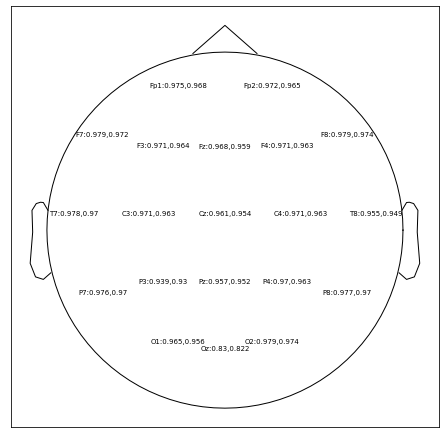

MessageError: ignored

In [0]:
## Visualize Results and Save Results
Today = datetime.date.today()
TodayStr = Today.strftime("%Y%m%d")
ResultFileName='SearchSpaceResult_2Ch_('+str(Best1Channel[0])+')_S'+str(subject_number)
ChannelFileName='ChannelNames_2Ch_('+str(Best1Channel[0])+')_S'+str(subject_number)
ImageFileName='SearchSpaceResult_2Ch_('+str(Best1Channel[0])+')_S'+str(subject_number)

if RemoveBaseLine==0:
  ResultFileName=ResultFileName+'_RemoveBaseLineOff'
  ChannelFileName=ChannelFileName+'_RemoveBaseLineOff'
  ImageFileName=ImageFileName+'_RemoveBaseLineOff'
else:
  ResultFileName=ResultFileName+'_RemoveBaseLineOn'
  ChannelFileName=ChannelFileName+'_RemoveBaseLineOn'
  ImageFileName=ImageFileName+'_RemoveBaseLineOn'


if Orthogonal==0:
  ResultFileName=ResultFileName+"_OrthogonalOff"
  ChannelFileName=ChannelFileName+'_OrthogonalOff'
  ImageFileName=ImageFileName+'_OrthogonalOff'
else:
  ResultFileName=ResultFileName+"_OrthogonalOn"
  ChannelFileName=ChannelFileName+'_OrthogonalOn'
  ImageFileName=ImageFileName+'_OrthogonalOn'
    
ResultFileName=ResultFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TodayStr+'.csv'
ChannelFileName=ChannelFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TodayStr+'.csv'
ImageFileName=ImageFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TodayStr+'.pdf'


# Visualize
biosemi_layout = mne.channels.read_layout('biosemi')
biosemi_Acc=copy.deepcopy(biosemi_layout)

for i in range(len(biosemi_Acc.names)):
    biosemi_Acc.names[i]=' '

    
for i in range(len(Search_Space_Channel)):
    index=biosemi_layout.names.index(Search_Space_Channel_Name[i])
    biosemi_Acc.names[index]=biosemi_layout.names[index]+":"+str(np.round(SearchSpaceResult[i][1],3))+\
                                                         ","+str(np.round(SearchSpaceResult[i][5],3))

ImageEEG=biosemi_Acc.plot()
# plt.title("Channel Name : Training Acc.  > Test Acc.",pad=-12)


# Save
ImageEEG.savefig(ImageFileName)

with open(ResultFileName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerows(SearchSpaceResult)

with open(ChannelFileName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(Search_Space_Channel)
    spamwriter.writerow(Search_Space_Channel_Name)
    
# Downlaod
import os
while os.path.isfile(ResultFileName)==False:
  print('wait')
  time.sleep(1)

files.download(ResultFileName)
files.download(ChannelFileName)
files.download(ImageFileName)